Python script to detect UK coins and count them

First, please upload a picture of some coins. Please note, that this program only works for square images.

In [41]:
from google.colab import files
uploaded = files.upload()

Saving IMG_20210327_145544~2.jpg to IMG_20210327_145544~2.jpg


Now, import all neccisary libraries and define colour correction functions

In [42]:
import numpy as np
import cv2
import argparse
import imutils
import math
from matplotlib import pyplot as plt
from matplotlib.axis import Axis
from google.colab.patches import cv2_imshow
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

# Colour correction algorithm taken from: 
# https://gist.github.com/DavidYKay/9dad6c4ab0d8d7dbf3dc
def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def simplest_cb(img, percent):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1

        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val = flat[int(math.floor(n_cols * half_percent))]
        high_val = flat[int(math.ceil( n_cols * (1.0 - half_percent)))]

        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, 
                                   cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)


Now import the image and perform initial processing.
This includes converting the image from BRG to RGB, performing Pyramid Means Shifting to make the image less detailed, and finally converting from RGB to HSV for colour detection and easy gray scaling.

([], <a list of 0 Text major ticklabel objects>)

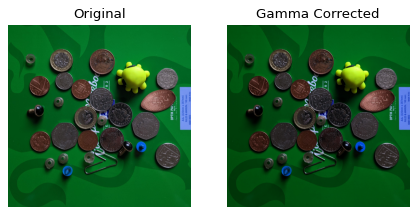

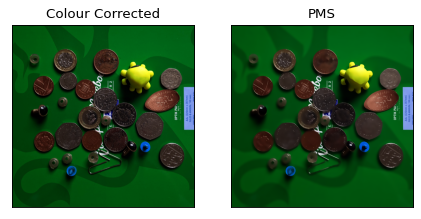

In [43]:
# import image and resize
filename = 'NO FILE UPLOADED'
for fn in uploaded.keys():
    filename = fn

img_bgr = cv2.imread(filename)
# convert to RGB
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# resize if image not from sample set
img_bgr = cv2.resize(img, (1600,1600), interpolation = cv2.INTER_AREA)

# show image before processing
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(131, aspect='auto', frameon=False)
ax.imshow(img, cmap='gray')
ax.set_title('Original')
plt.xticks([])
plt.yticks([])

# perform gama correction to emphisize the extreme ends of the image histogram
gamma = 0.8
invGamma = 1.0 / gamma
table = np.array([((i / 255.0) ** invGamma) * 255
  for i in np.arange(0, 256)]).astype("uint8")
img= cv2.LUT(img, table)

# convert the origina image to hsv and split.
(temp_hue, temp_sat, temp_val)=cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))

# perform basic colour correction of 5%
cc_img = simplest_cb(img, 2.5)

# convert the colour corrected image to hsv
(temp_hue2, temp_sat2, temp_val2) = cv2.split(cv2.cvtColor(cc_img, 
                                                           cv2.COLOR_RGB2HSV))

# performing colour correction can incorrectly increase the background 
# illumination. to correct this, swap out the value channels
# of the original and colour corrected images
cc_img = cv2.merge([temp_hue2, temp_sat2, temp_val])
cc_img = cv2.cvtColor(cc_img, cv2.COLOR_HSV2RGB)

# perform pyramid mean shift filtering for colour recognition
rgb_shifted = cv2.pyrMeanShiftFiltering(cc_img, 21, 51)

# convert to hsv
hsv_img = cv2.cvtColor(cc_img, cv2.COLOR_RGB2HSV)
hsv_shifted = cv2.cvtColor(rgb_shifted, cv2.COLOR_RGB2HSV)

# split to pull out gray scale
shifted_hue, shifted_sat, shifted_gray = cv2.split(hsv_shifted)
img_hue, img_sat, img_gray = cv2.split(hsv_img)

ax = fig.add_subplot(132, aspect='auto', frameon=False)
ax.imshow(img, cmap='gray')
ax.set_title('Gamma Corrected')
plt.xticks([])
plt.yticks([])

fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(131, aspect='auto')
ax.imshow(cc_img, cmap='gray')
ax.set_title('Colour Corrected')
plt.xticks([])
plt.yticks([])
ax = fig.add_subplot(132, aspect='auto')
ax.imshow(rgb_shifted, cmap='gray')
ax.set_title('PMS')
plt.xticks([])
plt.yticks([])


Plot the hue saturation and vaalue for the PMS image

([], <a list of 0 Text major ticklabel objects>)

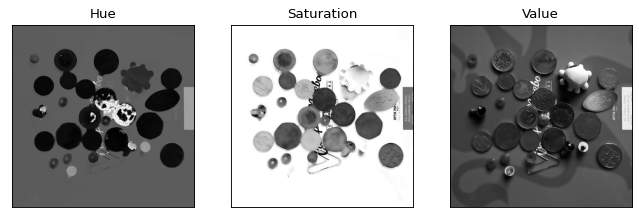

In [44]:

fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(131, aspect='auto')
ax.imshow(shifted_hue, cmap='gray', vmin=0, vmax=180)
ax.set_title('Hue')
plt.xticks([])
plt.yticks([])
ax = fig.add_subplot(132, aspect='auto')
ax.imshow(shifted_sat, cmap='gray', vmin=0, vmax=255)
ax.set_title('Saturation')
plt.xticks([])
plt.yticks([])
ax = fig.add_subplot(133, aspect='auto')
ax.imshow(shifted_gray, cmap='gray', vmin=0, vmax=255)
ax.set_title('Value')
plt.xticks([])
plt.yticks([])

Plot histogram of grayscale PMS image to show that simple bi-modal thresholding is reasonable.

Text(0, 0.5, 'Count')

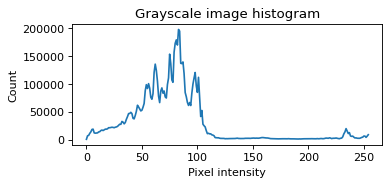

In [45]:
counts, vals = np.histogram(shifted_gray, bins=range(2 ** 8))
fig = plt.figure(figsize=(5, 2), dpi=80)
plt.plot(range(0, (2 ** 8) - 1), counts)
plt.title('Grayscale image histogram')
plt.xlabel('Pixel intensity')
plt.ylabel('Count')

Now, perform thresholding. Since copper coins are less reflective, they are sometimes missed by the bimodal thresholding. To account for this, a binary mask is created for all red pixles in the PMS image. A seperate binary image is created by performing Otsu thersholding on the PMS image. These two binaries are then combined via a bitwise_or

([], <a list of 0 Text major ticklabel objects>)

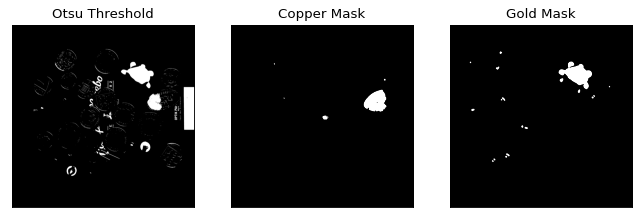

In [46]:
# detect red (copper coins)
red_mask = cv2.inRange(hsv_shifted, (0, 40, 100), (27, 255, 255))

# detect yllow (pound coins)
gold_mask = cv2.inRange(hsv_img, (20, 25, 100), (40, 255, 255))

# noise removal: gold mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
golds = cv2.dilate(gold_mask,kernel,iterations = 1)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
golds = cv2.morphologyEx(golds, cv2.MORPH_CLOSE, kernel, iterations = 5)
golds = cv2.morphologyEx(golds, cv2.MORPH_OPEN, kernel, iterations = 10)
#golds = cv2.dilate(golds,kernel,iterations = 10)

# noise removal: red mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
coppers = cv2.erode(red_mask,kernel,iterations = 5)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
coppers = cv2.dilate(coppers,kernel,iterations = 5)

# perform otsu thresholding
ret, gray_otsu = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret, shifted_otsu = cv2.threshold(shifted_gray,0,255,
                                  cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# add copper coins to otsu threshold output
final_threshold = cv2.bitwise_or(coppers, shifted_otsu)

# noise removal: final binary
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
final_threshold = cv2.dilate(final_threshold,kernel,iterations = 1)
final_threshold = cv2.erode(final_threshold,kernel,iterations = 3)
final_threshold = cv2.dilate(final_threshold,kernel,iterations = 1)

# Show results
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(131, aspect='auto')
ax.imshow(shifted_otsu, cmap='gray', vmin=0, vmax=255)
ax.set_title('Otsu Threshold')
plt.xticks([])
plt.yticks([])
ax = fig.add_subplot(132, aspect='auto')
ax.imshow(coppers, cmap='gray', vmin=0, vmax=180)
ax.set_title('Copper Mask')
plt.xticks([])
plt.yticks([])
ax = fig.add_subplot(133, aspect='auto')
ax.imshow(golds, cmap='gray', vmin=0, vmax=180)
ax.set_title('Gold Mask')
plt.xticks([])
plt.yticks([])


Now perform watershed segmentation using the combined binary as the seed.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO] 52 unique segments found


([], <a list of 0 Text major ticklabel objects>)

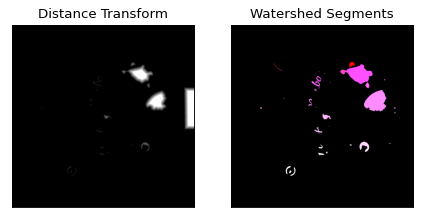

In [47]:
# Use a distance transform to find the distance of any 255 value pixel
# from the nearest 0 value pixel. This produces a distance map.
D = ndimage.distance_transform_edt(final_threshold)
# Now merge adjacent peaks in the distance map, to produce a single
# peak for each object
localMax = peak_local_max(D, indices=False, min_distance=50,
  labels=final_threshold)

# now perform watershed segmentation, using the peaks as the seed
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=final_threshold)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

labels_for_show=cv2.merge((labels*255, labels*5, labels**2))

fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(131, aspect='auto')
ax.imshow(D*4, cmap='gray', vmin=0, vmax=255)
ax.set_title('Distance Transform')
plt.xticks([])
plt.yticks([])
ax = fig.add_subplot(132, aspect='auto')
ax.imshow(labels_for_show, cmap='gray', vmin=0, vmax=255)
ax.set_title('Watershed Segments')
plt.xticks([])
plt.yticks([])


It is now possible to detect coins in the image.
To do this, a circle of best fit is drawn over each area identified in the watershed segmentation. The area of the shape within this circle is checked. Only shapes with an area within 20% of a perfect circle are concidered coins.

0


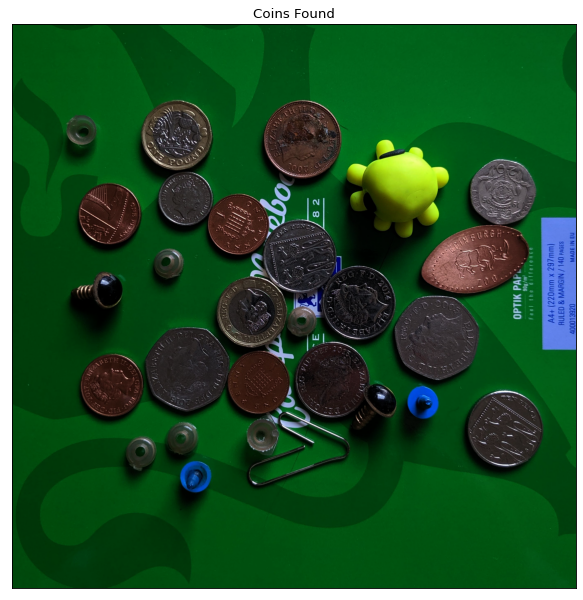

In [48]:
# remove all non-circular objects
coin_list = []

img_tmp = img.copy()

for label in np.unique(labels):
  # if the label is zero, we are examining the 'background'
  # so simply ignore it
  if label == 0:
    continue
  # otherwise, allocate memory for the label region and draw
  # it on the mask
  mask = np.zeros(final_threshold.shape, dtype="uint8")
  mask[labels == label] = 255
  # perform a closing to fill in any small holes in the mask
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations = 5)
  # detect contours in the mask and grab the largest one
  cnts = cv2.findContours(mask.copy(), cv2.RETR_TREE, 
                          cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)

  c = max(cnts, key=cv2.contourArea)

  # calculate bounding box
  rx,ry,rw,rh = cv2.boundingRect(c)
  # calculate circle enclosing the object
  ((cx, cy), cr) = cv2.minEnclosingCircle(c)

  # calculate blob moments and area
  M=cv2.moments(c)
  blob_area = cv2.contourArea(min(cnts, key=cv2.contourArea))
  circular_area = 3.14 * cr**2

  # only keep blobs whose area is 80% or more of a perfect circle
  if circular_area*0.80 < blob_area:
    coin_list.append(label)
    # draw bounding box
    rx,ry,rw,rh = cv2.boundingRect(c)
    cv2.rectangle(img_tmp, (rx,ry), (rx+rw, ry+rh), (255,255,0), 2)
    # draw a circle enclosing the object
    ((cx, cy), cr) = cv2.minEnclosingCircle(c)
    cv2.circle(img_tmp, (int(cx), int(cy)), int(cr), (0, 255, 0), 2)
    # write label of coin on coin
    cv2.putText(img_tmp, "{}".format(label), (int(cx) - 20, int(cy)),
      cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 15)
    cv2.putText(img_tmp, "{}".format(label), (int(cx) - 20, int(cy)),
      cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)


# Show results
fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_subplot(121, aspect='auto')
ax.imshow(img_tmp, cmap='gray', vmin=0, vmax=180)
ax.set_title('Coins Found')
plt.xticks([])
plt.yticks([])

print (len(coin_list))

Now that the coins have been identified, they can be clasfied and counted. The clasification will depend on comparing size ratios. However, first it is neccsary to identifying at least one coin by other means, such that all others may be compared to it.

First, check if there are any 50ps. These are easily identified by their straight edges.

The following coins are probably 50 pences:
[]


([], <a list of 0 Text major ticklabel objects>)

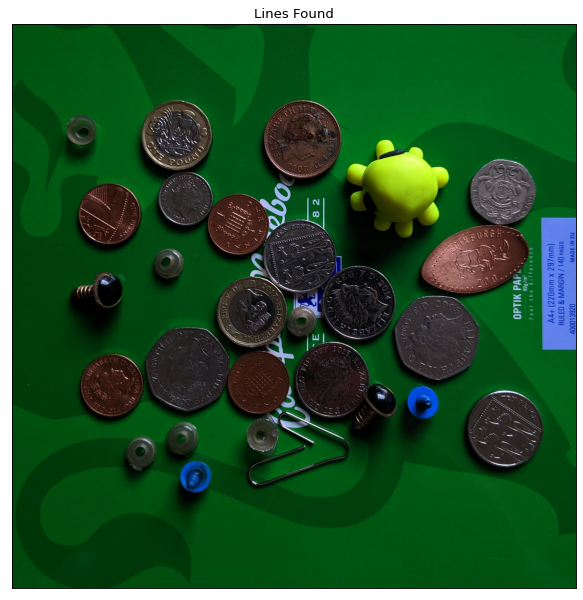

In [49]:
unsure_coins=[]
fifty_p_list=[]

img_tmp = img.copy()

for label in np.unique(coin_list):
  minLineLength = 30
  maxLineGap = 30

  # create a mask from the watershed segement
  mask = np.zeros(golds.shape, dtype="uint8")
  mask[labels == label] = 255
  # perform a closing to fill in any holes in the mask, as these
  # could lead to edges other than the outrmost being picked up as lines
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations = 2)
  # perform edge detection
  edges = cv2.Canny(mask,100,200,apertureSize = 3)
  kernel = np.ones((2,2),np.float32)
  edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations = 2)
  lines = cv2.HoughLinesP(edges,1,np.pi/180,20,
                          minLineLength=minLineLength,maxLineGap=maxLineGap)

  # if at least 3 lines were found on the edges of the coin then it's probably
  # a 50p. In this case add it to the list of 50ps. Else, add it to the list
  # of unsure coins
  if np.any(lines):
    for line in lines:
      coords = line[0]
      cv2.line(img_tmp, (coords[0], coords[1]), (coords[2], 
                                             coords[3]), [0,0,0], 20)
      cv2.line(img_tmp, (coords[0], coords[1]), (coords[2], 
                                             coords[3]), [0,255,0], 10)
    if (len(lines))>3:
      fifty_p_list.append(label)
    else:
      unsure_coins.append(label)
  else:
    unsure_coins.append(label)

  
  # detect contours in the mask and grab the largest one
  cnts = cv2.findContours(mask.copy(), cv2.RETR_TREE, 
                          cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # write label of coin on coin
  ((cx, cy), cr) = cv2.minEnclosingCircle(c)
  cv2.putText(img_tmp, "{}".format(label), (int(cx) - 20, int(cy)),
      cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 15)
  cv2.putText(img_tmp, "{}".format(label), (int(cx) - 20, int(cy)),
      cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)

print ("The following coins are probably 50 pences:")
print(fifty_p_list)

fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_subplot(121, aspect='auto')
ax.imshow(img_tmp, cmap='gray', vmin=0, vmax=180)
ax.set_title('Lines Found')
plt.xticks([])
plt.yticks([])





The coins can now be classified. First, the average size of the 50ps or pound coins is determainted. Then the radius of all other coins are compared to the average. The coins are classified based on their size relative to the known coins. 

The total value of money detected:  0


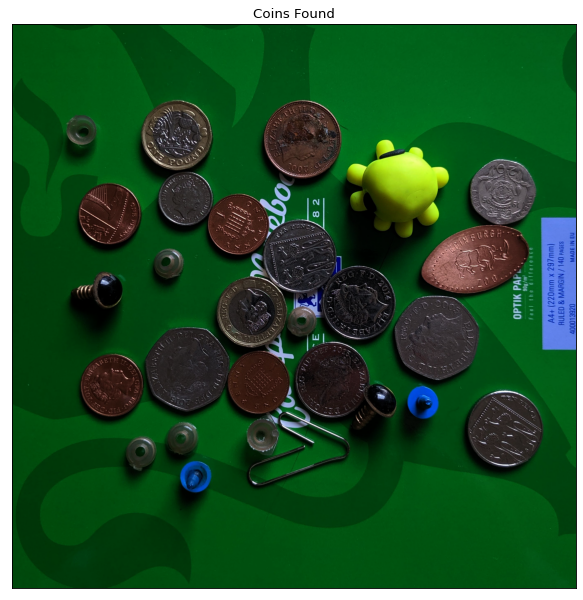

In [50]:
img_out = img.copy()

uncounted_coins = []
one_p_list = []
two_p_list = []
five_p_list = []
ten_p_list = []
twenty_p_list = []
one_pound_list = []
two_pound_list = []
fifty_p_radius =[]

money = 0

# make sure that at least 1 fifty pence coin has been identified
if np.any(fifty_p_list):
  # cycle through the list of 50 p coins
  for label in np.unique(fifty_p_list):
    # get coin dimensions
    mask = np.zeros(final_threshold.shape, dtype="uint8")
    mask[labels == label] = 255
    # perform a closing to fill in any holes in the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations = 5)
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # calculate circle enclosing the object
    ((fx, fy), fr) = cv2.minEnclosingCircle(c)

    value = 0.50

    # add value of coin to running total
    money = money + value

    # draw bounding box
    rx,ry,rw,rh = cv2.boundingRect(c)
    cv2.rectangle(img_out, (rx,ry), (rx+rw, ry+rh), (255,255,0), 2)
    # draw a circle enclosing the object
    cv2.circle(img_out, (int(fx), int(fy)), int(fr), (0, 255, 0), 2)
    # write value of coin on coin
    cv2.putText(img_out, "{}".format(value), (int(fx) - 20, int(fy)),
      cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 20)
    cv2.putText(img_out, "{}".format(value), (int(fx) - 20, int(fy)),
      cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 4)


  # using 50 pences as a base, comapare the size ratios of the unsure coins
  for label in np.unique(unsure_coins):

    # check shape and size from watershed
    mask = np.zeros(final_threshold.shape, dtype="uint8")
    mask[labels == label] = 255
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    ((cx, cy), cr) = cv2.minEnclosingCircle(c)
    circular_area = 3.14 * cr**2

    # measure amount of copper in coin
    mask = np.zeros(coppers.shape, dtype="uint8")
    mask[labels == label] = 255
    mask = cv2.bitwise_and(mask, coppers)
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    copper_area = 0
    if cnts:
      # calculate amount of copper colour in coin
      copper_area = cv2.contourArea(max(cnts, key=cv2.contourArea))

    # measure amount of gold in coin
    mask = np.zeros(golds.shape, dtype="uint8")
    mask[labels == label] = 255
    mask = cv2.bitwise_and(mask, golds)
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    gold_area = 0
    if cnts:
      # check if the gold area forms a ring
      gold_area = cv2.contourArea(max(cnts, key=cv2.contourArea))


    # create new list of 50ps for counting
    fifty_p_list[0]
    ratio = cr/fr 

    # ratios are derived from a list of coin sizes on wikipedia:
    # https://en.wikipedia.org/wiki/Coins_of_the_pound_sterling
    # upper and lower bounds represent +- 10%  to account for image deformation

    # now check for copper coins. these should show up at least 50% on
    # the copper mask
    if circular_area*0.5 < copper_area:
      if (0.86 < ratio < 1.04):
        two_p_list.append(label)
        value = 0.02
      elif (0.67 < ratio < 0.79):
        one_p_list.append(label)
        value = 0.01

    # now check for pound coins. The gold area is meaasured based on the outside
    # contour. As pound coins have a gold ring on the outside edge,
    # pound coins should return an almost perfectly circular area
    elif circular_area*0.7 < gold_area:
      if (0.77 < ratio < 0.93):
        one_pound_list.append(label)
        value = 1.00
      elif (0.94 < ratio < 1.14):
        two_pound_list.append(label)
        value = 2.00

    # now check for silver coins
    elif (0.3 < ratio <0.72):
      five_p_list.append(label)
      value = 0.05   
    elif (0.72 < ratio < 0.84):
      twenty_p_list.append(label)
      value = 0.20
    elif (0.84 < ratio < 0.95):
      ten_p_list.append(label)
      value = 0.10
    elif (0.95 < ratio < 1.1):
      fifty_p_list.append(label)
      value = 0.50

    # if there are still no matches, then the object may not be a UK coin
    else:
      uncounted_coins.append(label)
      value = 0

    # add the value of the coin onto the running total
    money = money + value

    
    # draw bounding box
    rx,ry,rw,rh = cv2.boundingRect(c)
    cv2.rectangle(img_out, (rx,ry), (rx+rw, ry+rh), (255,255,0), 2)
    # draw a circle enclosing the object
    cv2.circle(img_out, (int(cx), int(cy)), int(cr), (0, 255, 0), 2)
    # show the coin's value
    ((cx, cy), cr) = cv2.minEnclosingCircle(c)
    cv2.putText(img_out, "{}".format(value), (int(cx) - 20, int(cy)),
      cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 20)
    cv2.putText(img_out, "{}".format(value), (int(cx) - 20, int(cy)),
      cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 4)

# Show results
fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_subplot(121, aspect='auto')
ax.imshow(img_out, cmap='gray', vmin=0, vmax=180)
ax.set_title('Coins Found')
plt.xticks([])
plt.yticks([])

print("The total value of money detected: ", money)